In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pinns import * 

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Solving an ode for the damped harmonic oscilator $\frac{d^2 y}{d x^2} + 2\mu \frac{d y}{d x} + \omega^2 y = 0$
[link](https://en.wikipedia.org/wiki/Harmonic_oscillator)

In [9]:

mu, omega = 1, 20

boundary_X = torch.tensor([0.0])
boundary_f = torch.tensor([1.0])
# It is important to make sure for the physics_X .requires_grad_(True) 
# is called.
physics_X = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)


model = Net_dense([1, 32, 32, 1])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
epochs = 50000
loss_boundary = 0.0
lambda_boundary = 1.0
loss_physics = 0.0
lambda_physics = 1e-4

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    # data_f_hat = model(data_X)
    # loss_data = torch.mean((data_f - data_f_hat)**2)

    #################################
    # boundary loss
    boundary_f_hat = model(boundary_X)
    loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)

    #################################
    # initial conditoion loss
    # init_cond_f_hat = model(init_cond_X)
    # loss_init_cond = torch.mean((init_cond_f - init_cond_f_hat)**2)

    #################################
    # physics derivatives
    physics_f = model(physics_X)
    dx  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    ################################
    # physics loss
    # Construct the physics loss here
    diff_pde = dx2 + 2*mu*dx + (omega**2)*physics_f
    loss_physics = torch.mean(diff_pde**2)    

    total_loss = (
            #lambda_data*loss_data
        +lambda_boundary*loss_boundary
        #+lambda_init_cond*loss_init_cond
        +lambda_physics*loss_physics
                    )

    total_loss.backward()
    optimizer.step()


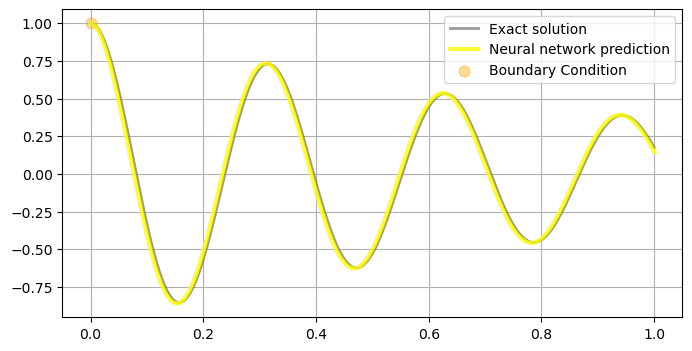

In [37]:
def f_harmonic(xs, mu, omega, x0):
    # We assume the oscilator is at speed = 0 at t=0
    # https://physicscourses.colorado.edu/phys2210/phys2210_fa20/lecture/lec36-damped-oscillator/
    assert mu < omega
    omega0 = np.sqrt(omega**2-mu**2)
    return x0*torch.exp(-mu*xs)*(torch.cos(omega0*xs) + torch.sin(omega0*xs)/(omega0*mu))

x = torch.linspace(0,1,500).view(-1,1)
y = f_harmonic(x, mu, omega, 1).view(-1,1)
yh = model(x).detach()
xp = physics_X.detach()
b_x = boundary_X.detach()
b_y = boundary_f.detach()
plt.figure(figsize=(8,4))
plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
plt.plot(x,yh, color="yellow", linewidth=3, alpha=0.8, label="Neural network prediction")
plt.scatter(b_x, b_y, s=60, color="orange", alpha=0.4, label='Boundary Condition')
plt.legend();plt.grid()
plt.show()
        


# Estimating the parameter $\mu$ in $\frac{d^2 y}{d x^2} + 2\mu \frac{d y}{d x} + \omega^2 y = 0$

In [54]:
mu_actual, omega = 1, 20

data_X = torch.linspace(0,1,30).view(-1,1)
data_f = f_harmonic(data_X, mu_actual, omega, x0=1) + torch.normal(0, 0.1, size=data_X.size())
# It is important to make sure for the physics_X .requires_grad_(True) 
# is called.
physics_X = torch.linspace(0,1,50).view(-1,1).requires_grad_(True)


mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
sampled_mus = []

model = Net_dense([1, 32, 32, 1])
optimizer = torch.optim.Adam(list(model.parameters())+[mu], lr=1e-3)
epochs = 50000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics = 1e-4

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    data_f_hat = model(data_X)
    loss_data = torch.mean((data_f - data_f_hat)**2)

    #################################
    # boundary loss
    # boundary_f_hat = model(boundary_X)
    # loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)

    #################################
    # initial conditoion loss
    # init_cond_f_hat = model(init_cond_X)
    # loss_init_cond = torch.mean((init_cond_f - init_cond_f_hat)**2)

    #################################
    # physics derivatives
    physics_f = model(physics_X)
    dx  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    ################################
    # physics loss
    # Construct the physics loss here
    diff_pde = dx2 + 2*mu*dx + (omega**2)*physics_f
    loss_physics = torch.mean(diff_pde**2)    

    total_loss = (
            lambda_data*loss_data
        #+lambda_boundary*loss_boundary
        #+lambda_init_cond*loss_init_cond
        +lambda_physics*loss_physics
                    )

    total_loss.backward()
    optimizer.step()

    sampled_mus.append(mu.item())

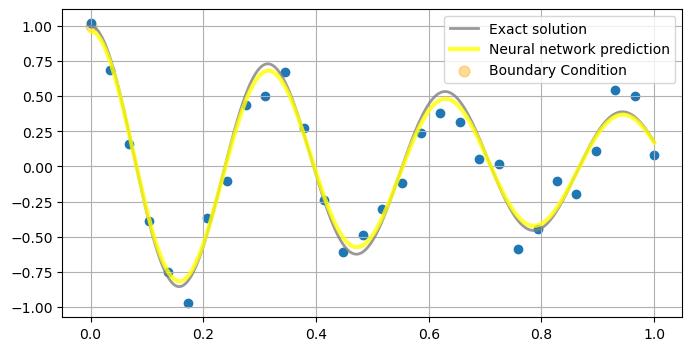

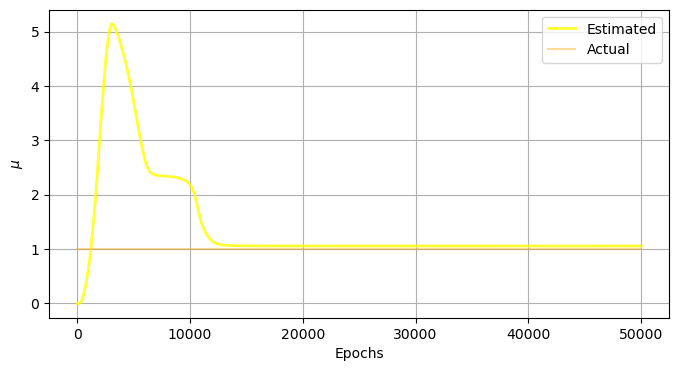

In [58]:
x = torch.linspace(0,1,500).view(-1,1)
y = f_harmonic(x, mu_actual, omega, 1).view(-1,1)
yh = model(x).detach()
xp = physics_X.detach()
b_x = boundary_X.detach()
b_y = boundary_f.detach()
plt.figure(figsize=(8,4))
plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
plt.plot(x,yh, color="yellow", linewidth=3, alpha=0.8, label="Neural network prediction")
plt.scatter(b_x, b_y, s=60, color="orange", alpha=0.4, label='Boundary Condition')
x_noisy = data_X.detach()
y_noisy = data_f.detach()
plt.scatter(x_noisy, y_noisy)
plt.legend();plt.grid()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(sampled_mus, color="yellow", linewidth=2, alpha=0.8, label="Estimated")
plt.plot([mu_actual] * len(sampled_mus), color="orange", alpha=0.4, label="Actual")
plt.xlabel("Epochs")
plt.ylabel(r"$\mu$")
plt.legend();plt.grid()
plt.show()

####  $\nabla^2 u(x,y) = 0$,
#### $u(0, y) = 1$,
#### $u(1, y) = 0$,
#### $u(x, 0) = 0$,
#### $u(x, 1) = 0$.

## Solution
#### $u(x,y) = \sum_{n=0}^{\infty} A_n \sinh(\frac{(n+1)\pi (x-1)}{M}) \sin(\frac{(n+1)\pi y}{M})$,
#### for
#### $A_n = -\frac{2}{M \sinh(\frac{(n+1)\pi}{M})} \int_0^M \sinh(\frac{(n+1)\pi y}{M}) dy =  -\frac{\frac{2M \cos(n \pi) + 2M}{n \pi + \pi}}{M \sinh(\frac{(n+1)\pi}{M})} = -\frac{2 \cos(n \pi) + 2}{(n \pi + \pi)(\sinh(\frac{(n+1)\pi}{M}))}$

[link](https://en.wikiversity.org/wiki/Partial_differential_equations/Laplace_Equation)

In [163]:
x = torch.linspace(0, 1, 32).to(device)
y = torch.linspace(0, 1, 32).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')


boundary_X_x = torch.hstack([x, 
                             x,
                             torch.ones_like(y)*x[0].item(), 
                             torch.ones_like(y)*x[-1].item()])
boundary_X_y = torch.hstack([torch.ones_like(x)*y[0].item(), 
                             torch.ones_like(x)*y[-1].item(),
                             y,
                             y])
boundary_X = torch.vstack([boundary_X_x, boundary_X_y]).T#.requires_grad_(True)
def boundary_function(x):
    return torch.where( x[:, 0] == 0, 
                       torch.sin(np.pi*x[:, 1]), 
                       0)
#     return torch.where( x[:, 0] == 0, 
#                        1, 
#                        0)

boundary_f = boundary_function(boundary_X).to(device)

physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([1., 1.]).to(device)
model = Net_dense_normalised([2, 32, 32, 1], lb, ub).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
epochs = 100000
loss_boundary = 0.0
lambda_boundary = 1.0
loss_physics = 0.0
lambda_physics = 8e-2


losses = np.zeros((3, epochs))

# solution = model(boundary_X).cpu().detach()#.reshape((x.shape[0], y.shape[0]))
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(boundary_X[:,0].cpu().detach(), 
#            boundary_X[:,1].cpu().detach(),
#            solution)

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    # data_f_hat = model(data_X)
    # loss_data = torch.mean((data_f - data_f_hat)**2)

    #################################
    # boundary loss
    boundary_f_hat = model(boundary_X).squeeze()
    loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)

    #################################
    # initial conditoion loss
    # init_cond_f_hat = model(init_cond_X)
    # loss_init_cond = torch.mean((init_cond_f - init_cond_f_hat)**2)

    #################################
    # physics derivatives
    physics_f = model(physics_X).squeeze()
    dxy  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy),  create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,0]
    laplacian = dx2 + dy2
    ################################
    # physics loss
    # Construct the physics loss here
    loss_physics = torch.mean(laplacian**2)    
    
    total_loss = (
            #lambda_data*loss_data
        +lambda_boundary*loss_boundary
        #+lambda_init_cond*loss_init_cond
        +lambda_physics*loss_physics
                    )

    total_loss.backward(retain_graph=True)
    optimizer.step()
    losses[:,i] = (total_loss.item(), loss_boundary.item(), loss_physics.item())


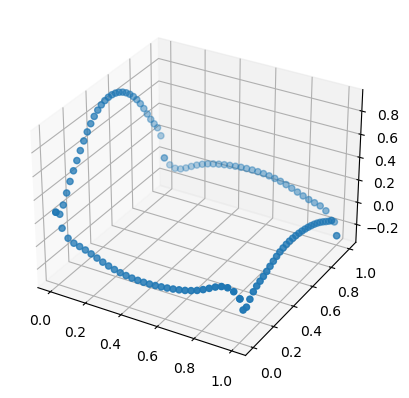

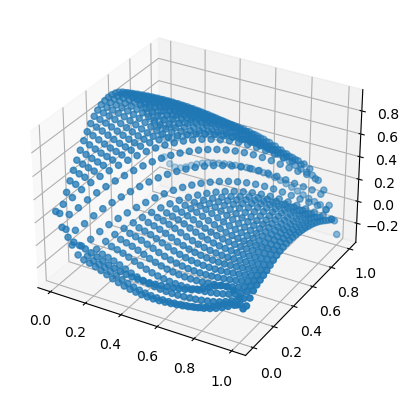

In [164]:
solution = model(boundary_X).cpu().detach()#.reshape((x.shape[0], y.shape[0]))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(boundary_X[:,0].cpu().detach(), 
            boundary_X[:,1].cpu().detach(),
           solution)
solution = model(physics_X).cpu().detach()#.reshape((x.shape[0], y.shape[0]))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(physics_X[:,0].cpu().detach(), 
            physics_X[:,1].cpu().detach(),
           solution)


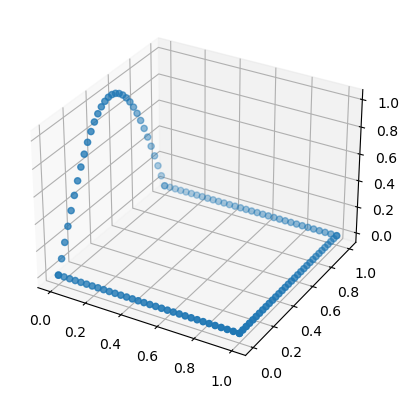

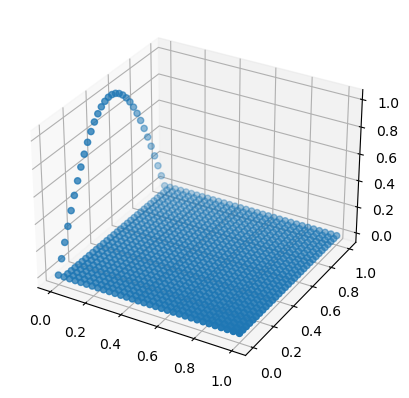

In [165]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(boundary_X[:,0].cpu().detach(), 
           boundary_X[:,1].cpu().detach(),
           boundary_f.cpu().detach())

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(physics_X[:,0].cpu().detach(), 
           physics_X[:,1].cpu().detach(),
           boundary_function(physics_X).cpu().detach())

In [166]:
boundary_X.shape

torch.Size([128, 2])

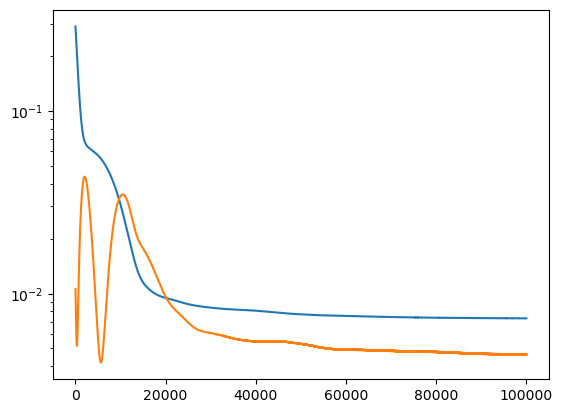

In [167]:
plt.plot(losses[1,:])
plt.plot(losses[2,:])
plt.yscale('log')

In [168]:
loss_physics, loss_boundary

(tensor(0.0046, device='cuda:2', grad_fn=<MeanBackward0>),
 tensor(0.0073, device='cuda:2', grad_fn=<MeanBackward0>))

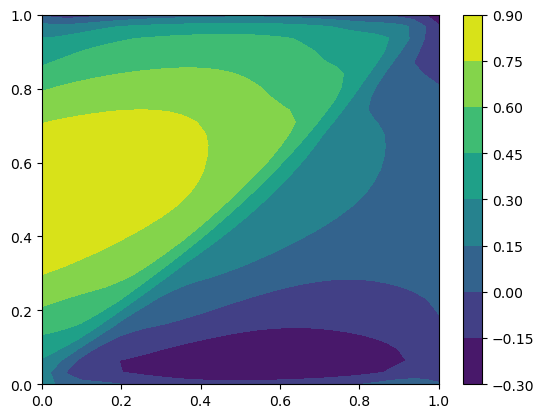

In [169]:
x = torch.linspace(0, 1, 32).to(device)
y = torch.linspace(0, 1, 32).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
solution = model(torch.vstack([X.flatten(), Y.flatten()]).T).cpu().detach().reshape((x.shape[0], y.shape[0]))
plt.contourf(X.cpu().detach(), Y.cpu().detach(), solution)
plt.colorbar()